In [51]:
# LOAD LIBRARIES
from tqdm import tqdm
import pandas as pd, numpy as np
import cudf, cupy
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
from config import read_config, update_config
from util import save_pickle
import dataset
print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [3]:
config = read_config("Base")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 2
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/Base/


In [4]:
# LOAD TRAIN
train =  cudf.read_csv(config.kaggle_data_folder + "/train.csv")
test = cudf.read_csv(config.kaggle_data_folder + "/test.csv")

In [7]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [8]:
train.drop(columns=["pressure"], inplace=True)

In [9]:
train = cudf.concat([train,test],axis=0)
exhale = 80-train.groupby('breath_id')[['u_out']].agg('sum')
length = train.groupby('breath_id')[['time_step']].agg('max')
print('Train shape:',train.shape)
train.head()

Train shape: (10060000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,1,20,50,0.000000,0.083334,0
1,2,1,20,50,0.033652,18.383041,0
2,3,1,20,50,0.067514,22.509278,0
3,4,1,20,50,0.101542,22.808822,0
4,5,1,20,50,0.135756,25.355850,0


In [10]:
# CONVERT TRAIN TO SERIES
series = train.groupby('breath_id').collect().reset_index()
for k in range(80): series[f'x_{k}'] = series.u_in.list.get(k)
#for k in range(80): series[f'y_{k}'] = series.pressure.list.get(k)
for k in range(80): series[f'z_{k}'] = 1-series.u_out.list.get(k)
series.R = series.R.list.get(0)
series.C = series.C.list.get(0)
series = series.drop(['id','time_step','u_in','u_out'],axis=1)
series = series.merge(exhale,on='breath_id',how='left')
series = series.merge(length,on='breath_id',how='left')
series = series.rename({'time_step':'time_length','u_out':'expire'},axis=1)
series = series.sort_values('breath_id').reset_index(drop=True)

print('Train as series shape:', series.shape )
print('Min inhale length=', series['expire'].min(),',Max inhale length=', series['expire'].max(),
      'Max breath length=',series['time_length'].max() )
series.head()

Train as series shape: (125750, 165)
Min inhale length= 25 ,Max inhale length= 32 Max breath length= 2.937237977981568


,breath_id,R,C,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_72,z_73,z_74,z_75,z_76,z_77,z_78,z_79,expire,time_length
0,0,5,20,0.000000,7.515046,14.651675,21.230610,26.320956,30.486938,33.545950,...,0,0,0,0,0,0,0,0,31,2.519844
1,1,20,50,0.083334,18.383041,22.509278,22.808822,25.355850,27.259866,27.127486,...,0,0,0,0,0,0,0,0,30,2.689766
2,2,20,20,12.184338,13.980205,12.574163,11.730537,12.124229,11.055636,10.774428,...,0,0,0,0,0,0,0,0,29,2.690624
3,3,50,20,0.000000,7.187242,13.338781,17.111335,18.353980,17.417672,15.353111,...,0,0,0,0,0,0,0,0,32,2.525398
4,4,50,50,0.000000,1.262539,4.001352,6.379411,8.295194,9.790410,10.874443,...,0,0,0,0,0,0,0,0,32,2.528579


In [11]:
from cuml.cluster import KMeans

In [12]:
series["fold"] = np.random.randint(low=0,high=4,size=len(series))

In [13]:
series

,breath_id,R,C,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_73,z_74,z_75,z_76,z_77,z_78,z_79,expire,time_length,fold
0,0,5,20,0.000000,7.515046,14.651675,21.230610,26.320956,30.486938,33.545950,...,0,0,0,0,0,0,0,31,2.519844,2
1,1,20,50,0.083334,18.383041,22.509278,22.808822,25.355850,27.259866,27.127486,...,0,0,0,0,0,0,0,30,2.689766,0
2,2,20,20,12.184338,13.980205,12.574163,11.730537,12.124229,11.055636,10.774428,...,0,0,0,0,0,0,0,29,2.690624,3
3,3,50,20,0.000000,7.187242,13.338781,17.111335,18.353980,17.417672,15.353111,...,0,0,0,0,0,0,0,32,2.525398,2
4,4,50,50,0.000000,1.262539,4.001352,6.379411,8.295194,9.790410,10.874443,...,0,0,0,0,0,0,0,32,2.528579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125745,125745,50,50,15.564236,23.588836,20.298696,12.326433,10.807906,11.630441,10.997722,...,0,0,0,0,0,0,0,31,2.508653,3
125746,125746,50,20,6.905471,75.198310,50.982377,0.000000,0.000000,16.101901,39.468039,...,0,0,0,0,0,0,0,32,2.522813,2
125747,125747,50,10,21.957377,17.311344,13.192400,8.764069,4.151136,0.826441,1.180669,...,0,0,0,0,0,0,0,29,2.721009,2
125748,125748,20,10,9.985853,35.151391,0.000000,0.000000,14.323999,1.385073,0.000000,...,0,0,0,0,0,0,0,30,2.665301,2


In [25]:
# FIRST 3 COLUMNS OF TRAIN SERIES DATAFRAME NEED TO BE IGNORED
IGNORE = 3
MIN_CLUSTER = 2
MAX_CLUSTER = 70
TIME_STEPS = 32
SKIP = 0 
series_valid = series[series["fold"] == 0]
series_train = series[series["fold"] != 0]
scores_train = []
scores_valid = []
for n_clusters in tqdm(range(MIN_CLUSTER, MAX_CLUSTER+1)):
    model = KMeans(n_clusters=n_clusters, random_state=2021)
    model.fit(series_train.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
    score_train = model.score(series_train.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
    score_valid = model.score(series_valid.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
    scores_train.append(score_train)
    scores_valid.append(score_valid)

100%|███████████████████████████████████████████████████████████████████████████| 69/69 [01:05<00:00,  1.05it/s]


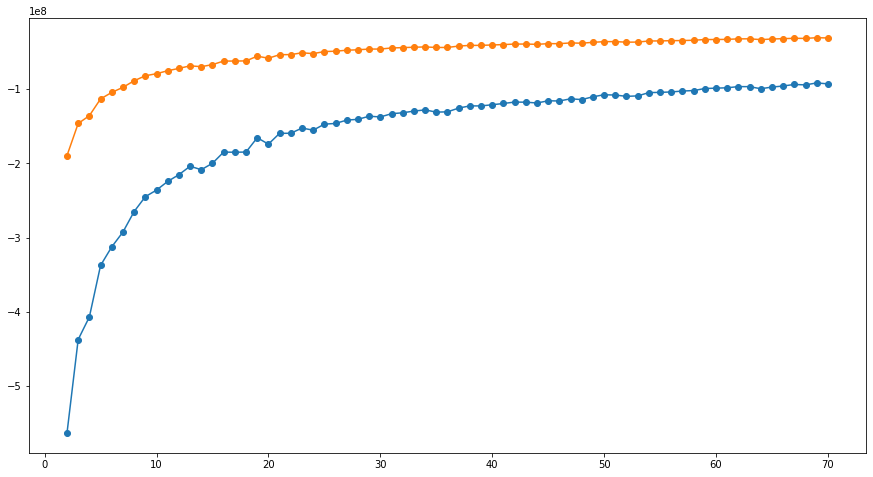

In [30]:
plt.subplots(1,1,figsize=(15,8))
plt.plot(list(range(MIN_CLUSTER, MAX_CLUSTER+1)), scores_train, "-o", label="train")
plt.plot(list(range(MIN_CLUSTER, MAX_CLUSTER+1)), scores_valid, "-o", label="valid")
plt.show()

In [31]:
model_s = KMeans(n_clusters=10, random_state=2021)
model_m = KMeans(n_clusters=15, random_state=2021)
model_l = KMeans(n_clusters=25, random_state=2021)

In [34]:
series["cluster_s"] = model_s.fit_predict(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
series["cluster_m"] = model_m.fit_predict(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
series["cluster_l"] = model_l.fit_predict(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])

In [35]:
series.head()

,breath_id,R,C,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_76,z_77,z_78,z_79,expire,time_length,fold,cluster_s,cluster_m,cluster_l
0,0,5,20,0.000000,7.515046,14.651675,21.230610,26.320956,30.486938,33.545950,...,0,0,0,0,31,2.519844,2,2,1,17
1,1,20,50,0.083334,18.383041,22.509278,22.808822,25.355850,27.259866,27.127486,...,0,0,0,0,30,2.689766,0,2,1,17
2,2,20,20,12.184338,13.980205,12.574163,11.730537,12.124229,11.055636,10.774428,...,0,0,0,0,29,2.690624,3,8,9,2
3,3,50,20,0.000000,7.187242,13.338781,17.111335,18.353980,17.417672,15.353111,...,0,0,0,0,32,2.525398,2,2,9,2
4,4,50,50,0.000000,1.262539,4.001352,6.379411,8.295194,9.790410,10.874443,...,0,0,0,0,32,2.528579,1,2,9,2


125750 10 10


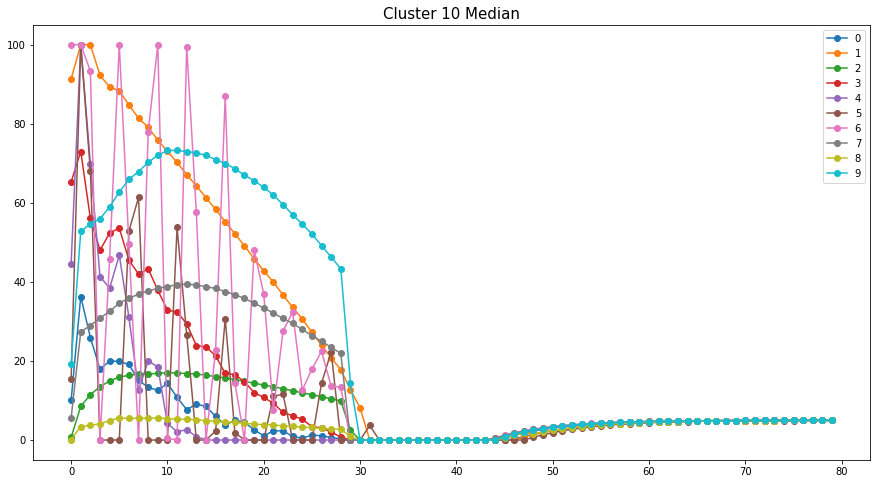

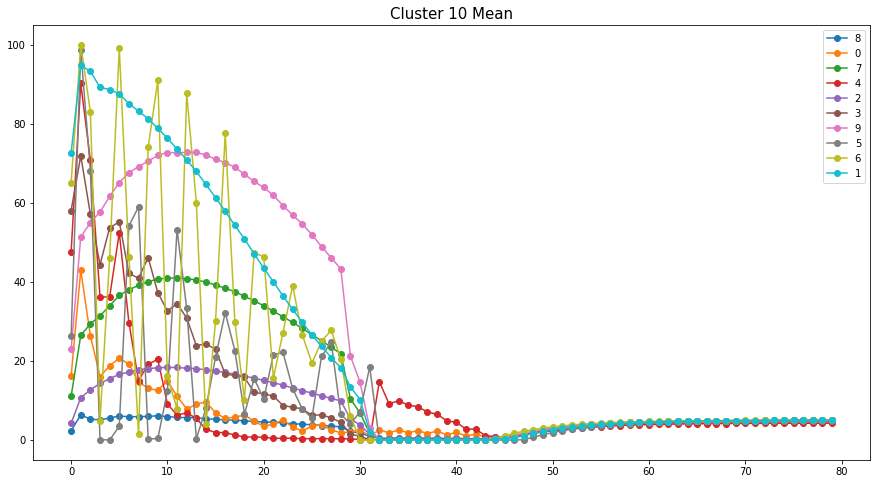

125750 15 15


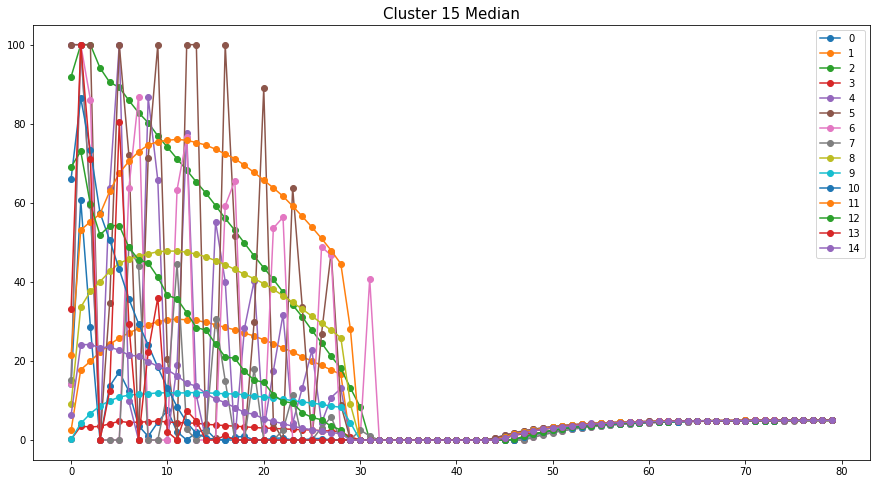

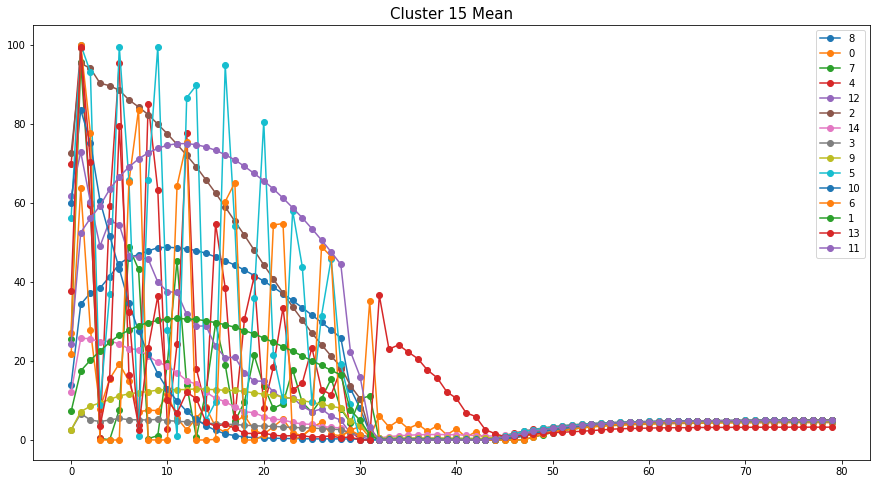

125750 25 25


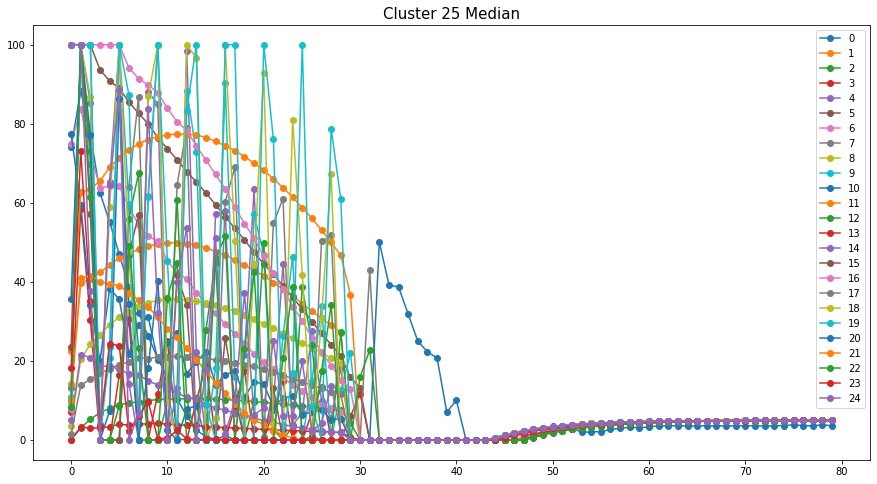

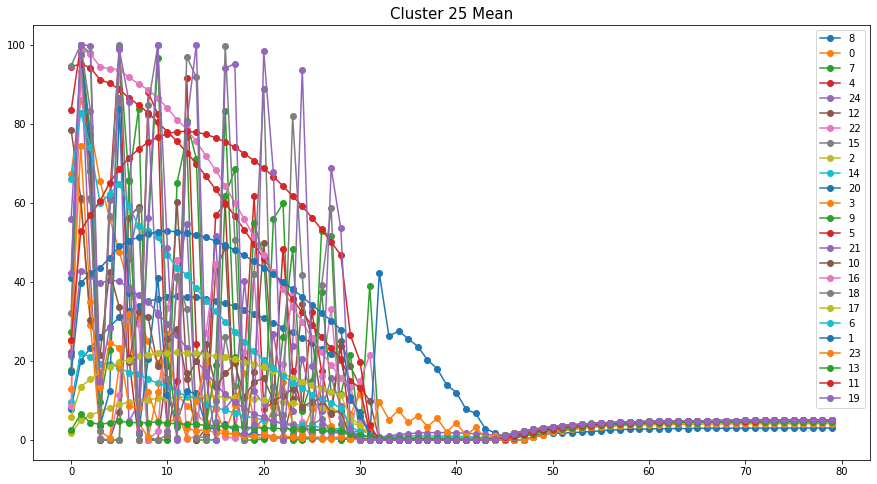

125750 40 40


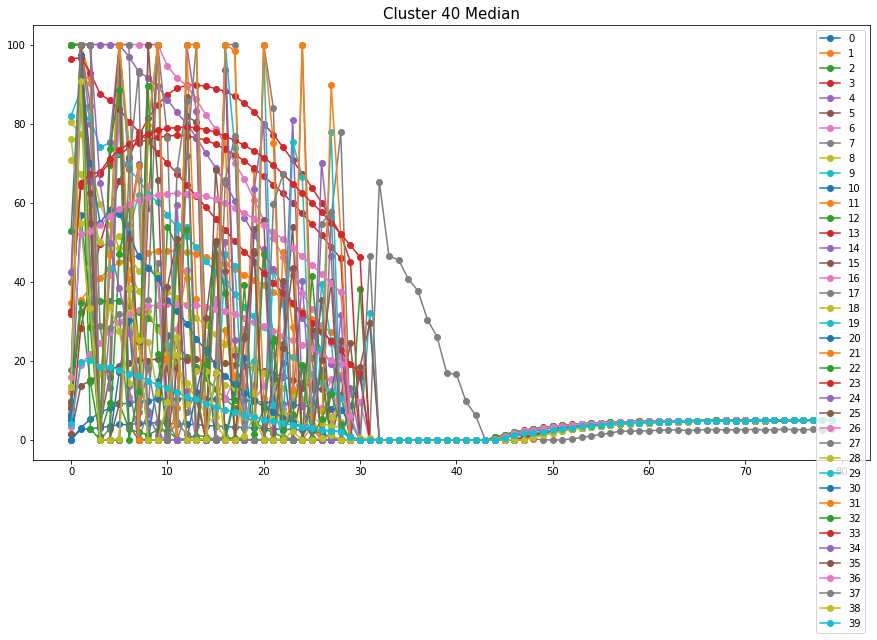

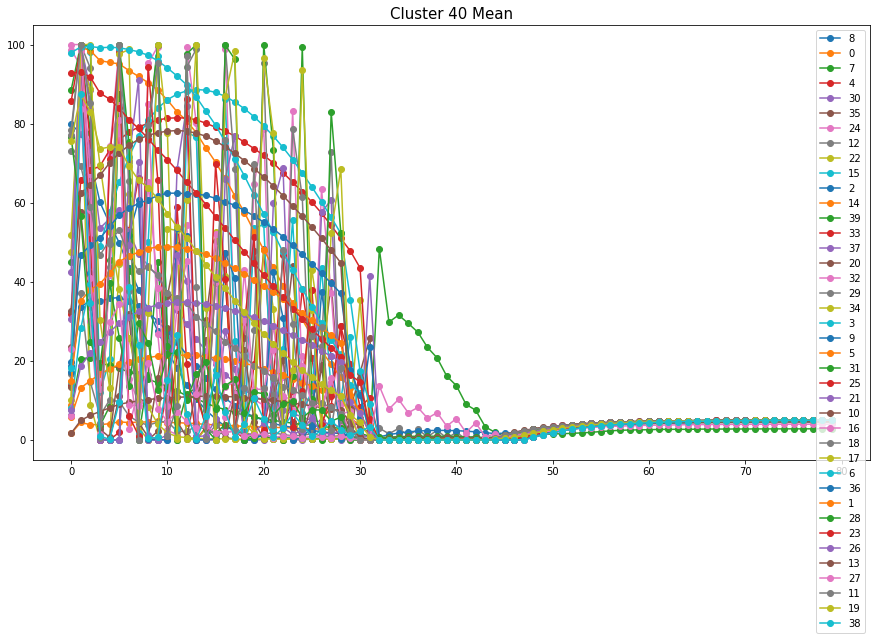

In [56]:
for n_cluster in [10, 15, 25, 40]:
    model = KMeans(n_clusters=n_cluster, random_state=2021)
    series["cluster"] = model.fit_predict(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
    u_in_median = series.groupby("cluster")[[f"x_{i}" for i in range(80)]].median()
    u_in_mean = series.groupby("cluster")[[f"x_{i}" for i in range(80)]].mean()
    
    id_cluster = series.groupby("breath_id")["cluster"].last().to_pandas().to_dict()
    u_in_median_dict = dict(zip(u_in_median.to_pandas().index, u_in_median.to_pandas().values))
    u_in_mean_dict = dict(zip(u_in_mean.to_pandas().index, u_in_mean.to_pandas().values))
    
    print(len(id_cluster), len(u_in_median_dict), len(u_in_mean))
    save_pickle(u_in_median_dict, f"../input/cluster_u_in_median_{n_cluster}.pkl")
    save_pickle(u_in_mean_dict, f"../input/cluster_u_in_mean_{n_cluster}.pkl")
    save_pickle(id_cluster, f"../input/cluster_id_{n_cluster}.pkl")
    
    plt.subplots(1,1,figsize=(15,8))
    for key, u_in in u_in_median_dict.items():
        plt.plot(list(range(80)),u_in,"-o", label=key)
    plt.legend()
    plt.title(f"Cluster {n_cluster} Median", size=15)
    plt.show()

    plt.subplots(1,1,figsize=(15,8))
    for key, u_in in u_in_mean_dict.items():
        plt.plot(list(range(80)),u_in,"-o", label=key)
    plt.legend()
    plt.title(f"Cluster {n_cluster} Mean", size=15)
    plt.show()

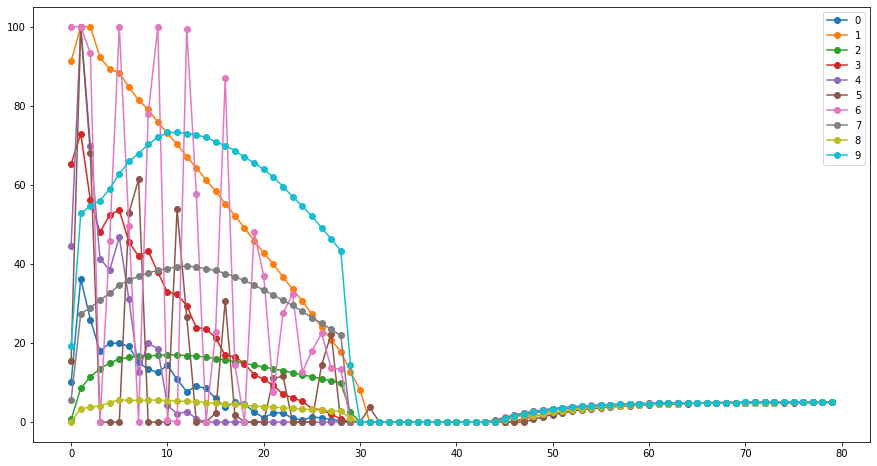

In [50]:
u_in_median_m = series.groupby("cluster_m")[[f"x_{i}" for i in range(80)]].median()
u_in_median_dict_s = dict(zip(u_in_median_s.to_pandas().index, u_in_median_s.to_pandas().values))
plt.subplots(1,1,figsize=(15,8))
for key, u_in in u_in_median_dict_s.items():
    plt.plot(list(range(80)),u_in,"-o", label=key)
plt.legend()

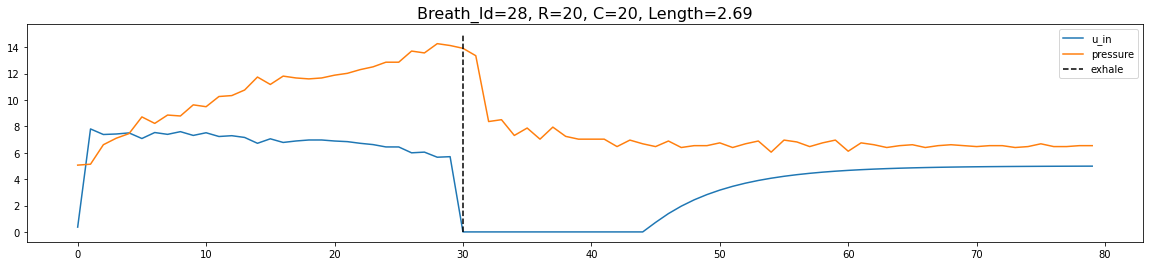

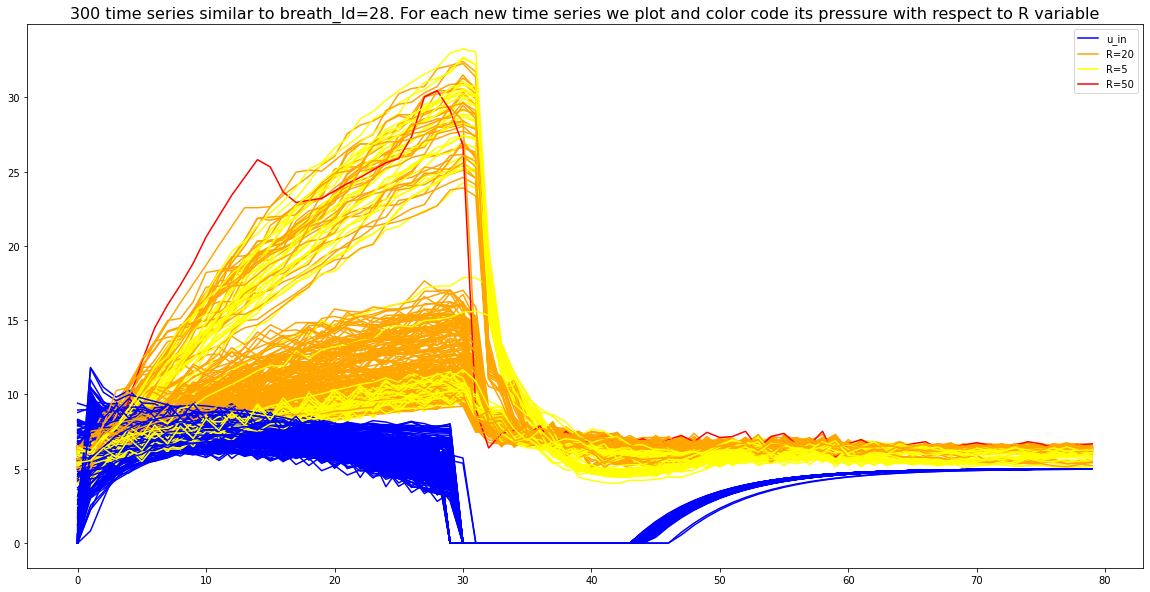

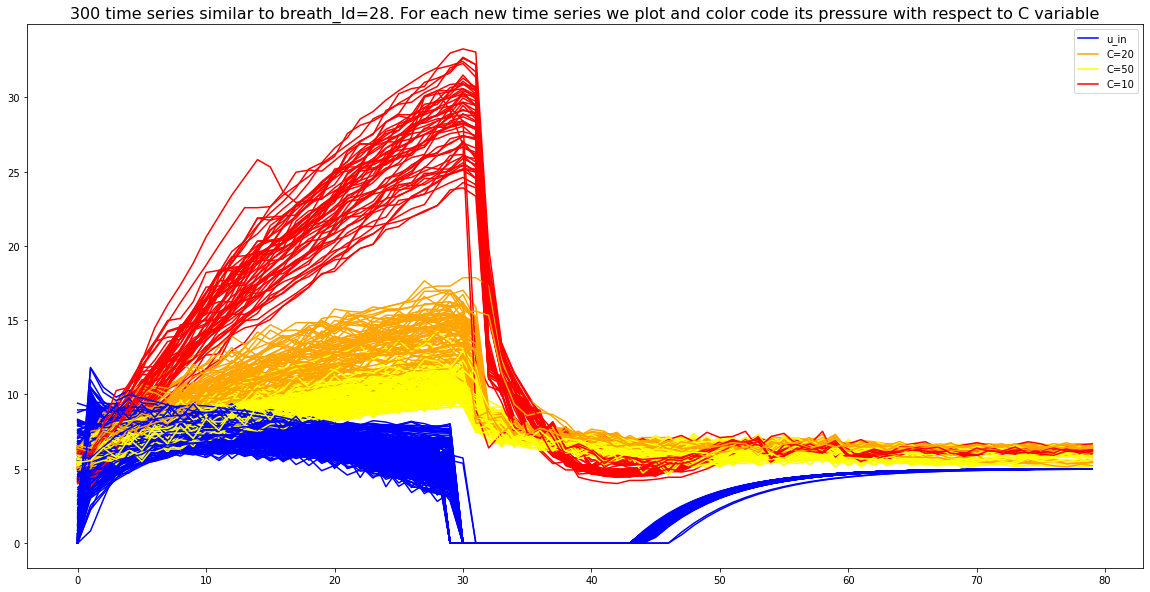

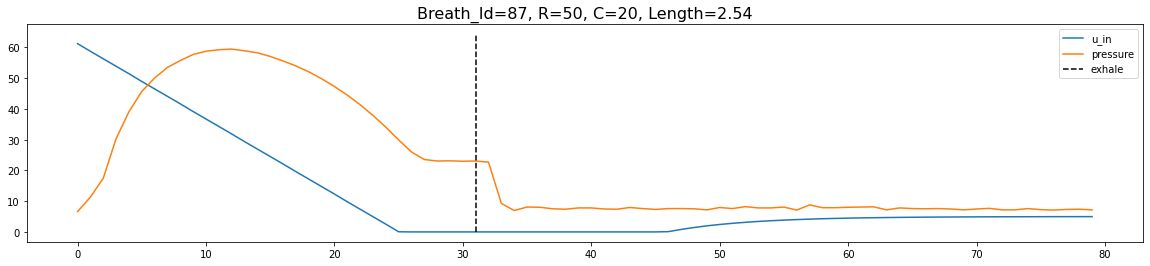

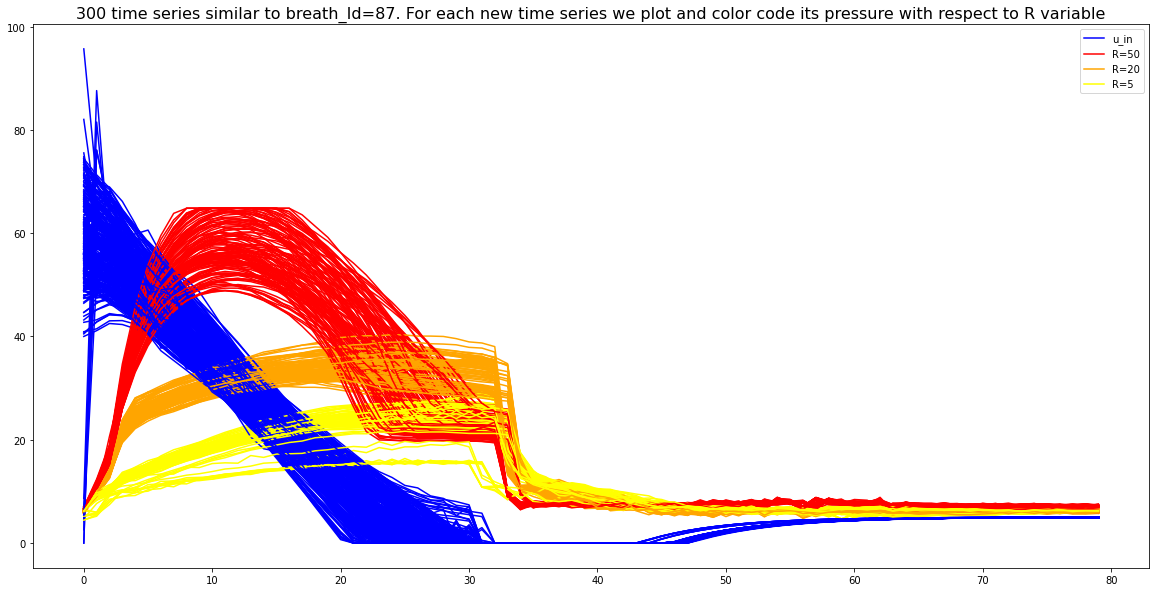

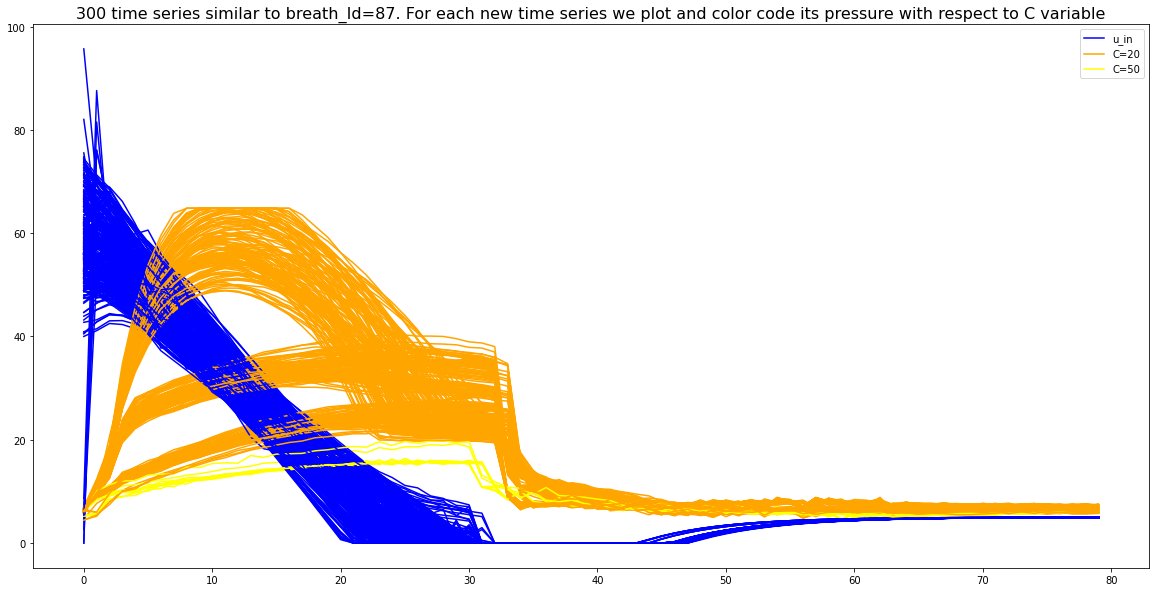

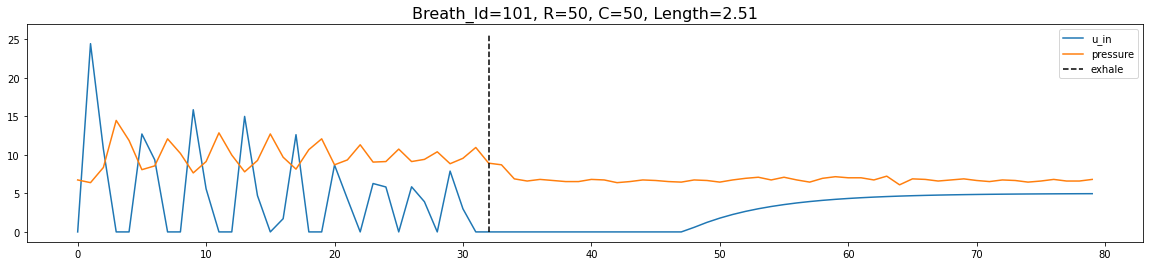

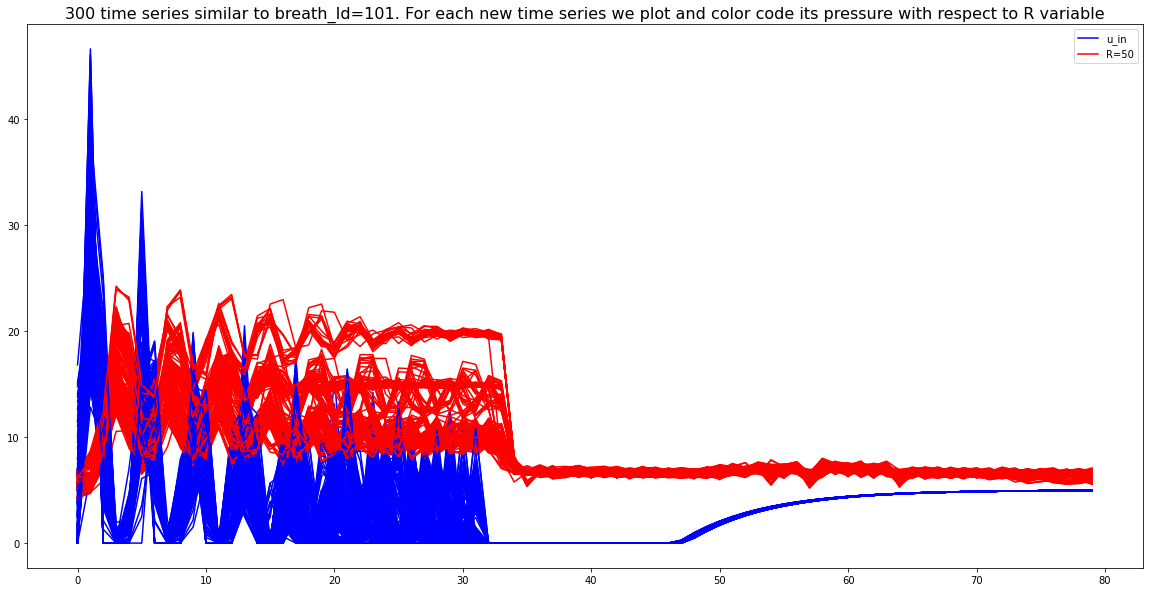

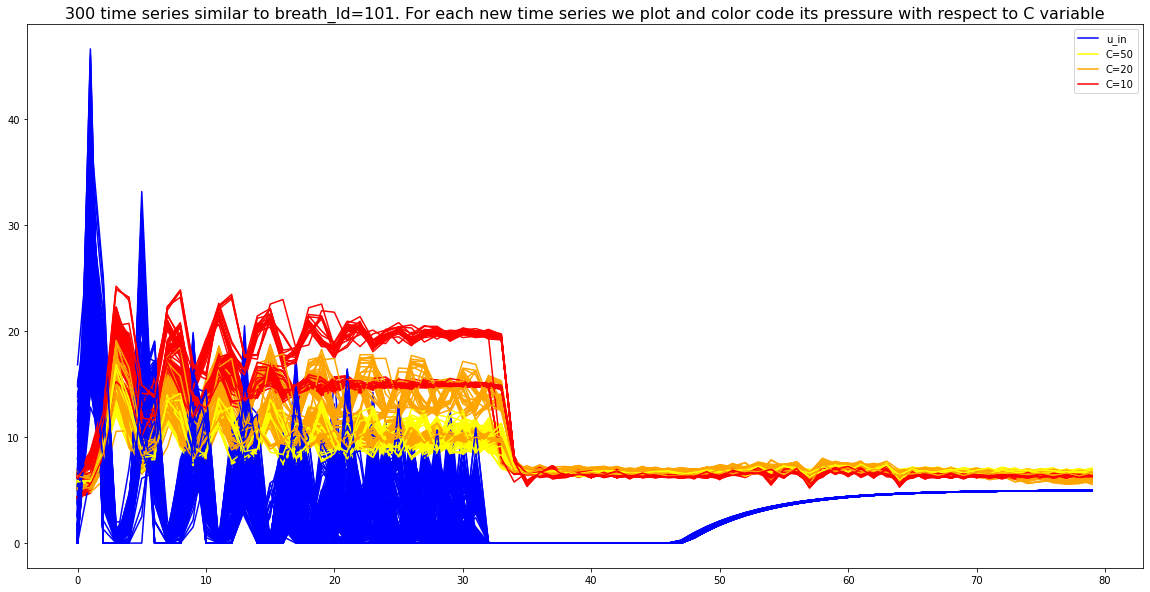

In [12]:
from cuml.neighbors import NearestNeighbors 

# FIRST 3 COLUMNS OF TRAIN SERIES DATAFRAME NEED TO BE IGNORED
IGNORE = 3
# MORE NEIGHBORS THAN WE NEED FOR ALL DISPLAYS
NEIGHBORS = 500
# HOW MANY TIME_STEPS TO USE FOR KNN COMPARISON
TIME_STEPS = 80
# HOW MANY INITIAL TIME_STEPS TO SKIP FOR KNN COMPARISON
SKIP = 0 

model = NearestNeighbors(n_neighbors=NEIGHBORS, metric='l1')
model.fit(series.iloc[:,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])

SHOW = [24,68,75]
CTS = [300]*len(SHOW)

for USE,CT in zip(SHOW,CTS):
    distances, indices = model.kneighbors(series.iloc[USE:USE+1,IGNORE+SKIP:IGNORE+TIME_STEPS+SKIP])
        
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(80),series.iloc[USE,IGNORE:IGNORE+80].to_array(),label='u_in')
    plt.plot(np.arange(80),series.iloc[USE,IGNORE+80:IGNORE+160].to_array(),label='pressure')
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    exhale = series.loc[USE,'expire']
    plt.plot([exhale,exhale],[0,y_max],'--',color='black',label='exhale')
    rr = series.loc[USE,'R']; cc = series.loc[USE,'C']; 
    bb = series.loc[USE,'breath_id']; tt = series.loc[USE,'time_length']
    plt.title(f'Breath_Id={bb}, R={rr}, C={cc}, Length={tt:.3}',size=16)
    plt.legend()
    
    temp2 = series.iloc[indices.iloc[0].values].reset_index(drop=True)
    cdict = {5: 'yellow', 20: 'orange', 50: 'red'}
    plt.figure(figsize=(20,10))
    legend = {5:0, 20:0, 50:0}
    for r in range(CT):
        if r==0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue', label='u_in')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
        if legend[temp2.loc[r,'R']]==0:
            legend[temp2.loc[r,'R']]=1; cc = temp2.loc[r,'R']
            plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'R']], label=f'R={cc}')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'R']])
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    plt.title(f'{CT} time series similar to breath_Id={bb}. For each new time series we plot and color code its pressure with respect to R variable',size=16)
    plt.legend()
    plt.show()
    
    temp2 = series.iloc[indices.iloc[0].values].reset_index(drop=True)
    cdict = {10: 'red', 20: 'orange', 50: 'yellow'}
    plt.figure(figsize=(20,10))
    legend = {10:0, 20:0, 50:0}
    for r in range(CT):
        if r==0: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue',label='u_in')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE:IGNORE+80].to_array(), color='blue')
        if legend[temp2.loc[r,'C']]==0:
            legend[temp2.loc[r,'C']]=1; cc = temp2.loc[r,'C']
            plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), 
                     c=cdict[temp2.loc[r,'C']], label=f'C={cc}')
        else: plt.plot(np.arange(80), temp2.iloc[r,IGNORE+80:IGNORE+160].to_array(), c=cdict[temp2.loc[r,'C']])
    y_max = plt.ylim()[1]
    if TIME_STEPS!=80: plt.plot([SKIP+TIME_STEPS-1,SKIP+TIME_STEPS-1],[0,y_max],'--',color='gray')
    if SKIP!=0: plt.plot([SKIP-1,SKIP-1],[0,y_max],'--',color='gray')
    plt.title(f'{CT} time series similar to breath_Id={bb}. For each new time series we plot and color code its pressure with respect to C variable',size=16)
    plt.legend()
    plt.show()

# Build Features

In [13]:
# LOAD TEST
test = cudf.read_csv(config.kaggle_data_folder + '/test.csv')
exhale = 80-test.groupby('breath_id')[['u_out']].agg('sum')
length = test.groupby('breath_id')[['time_step']].agg('max')
first_id = test.groupby('breath_id')[['id']].agg('min')
print('Test shape:',test.shape)
test.head()

Test shape: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [14]:
# CONVERT TEST TO SERIES
test_series = test.groupby('breath_id').collect().reset_index()
for k in range(80): test_series[f'x_{k}'] = test_series.u_in.list.get(k)
for k in range(80): test_series[f'z_{k}'] = 1-test_series.u_out.list.get(k)
test_series.R = test_series.R.list.get(0)
test_series.C = test_series.C.list.get(0)
test_series = test_series.drop(['id','time_step','u_in','u_out'],axis=1)
test_series = test_series.merge(exhale,on='breath_id',how='left')
test_series = test_series.merge(length,on='breath_id',how='left')
test_series = test_series.merge(first_id,on='breath_id',how='left')
test_series = test_series.sort_values('breath_id').reset_index(drop=True)
test_series = test_series.rename({'time_step':'time_length','u_out':'expire','id':'first_id'},axis=1)

print('Test as series shape:', test_series.shape )
print('Min inhale length=', test_series['expire'].min(),',Max inhale length=', test_series['expire'].max(),
      'Max breath length=',test_series['time_length'].max() )
test_series.head()

Test as series shape: (50300, 166)
Min inhale length= 25 ,Max inhale length= 32 Max breath length= 2.9352025985717773


,breath_id,R,C,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_73,z_74,z_75,z_76,z_77,z_78,z_79,expire,time_length,first_id
0,0,5,20,0.000000,7.515046,14.651675,21.230610,26.320956,30.486938,33.545950,...,0,0,0,0,0,0,0,31,2.519844,1
1,8,5,50,16.140384,11.429617,13.755544,9.306066,12.743169,7.150991,11.984329,...,0,0,0,0,0,0,0,29,2.689998,81
2,11,50,10,33.717608,26.595397,20.281570,13.548649,6.483971,1.112624,1.551207,...,0,0,0,0,0,0,0,29,2.722669,161
3,24,50,10,1.203812,3.150063,4.900224,6.484965,7.846378,9.015769,10.016142,...,0,0,0,0,0,0,0,30,2.675477,241
4,31,20,50,100.000000,58.192753,12.083520,13.780551,48.687221,23.392914,5.957594,...,0,0,0,0,0,0,0,29,2.688264,321


In [ ]:
from cuml.neighbors import NearestNeighbors 
NEIGHBORS = 2
SIZE = 80

# OOF
all_true = []
all_oof = []
all_true_inhale = []
all_oof_inhale = []

# TEST PREDS
all_pred = []
all_test_id = []

for r in [5,20,50]:
    for c in [10,20,50]:
        
        # FIT TRAIN KNN
        temp2 = series.loc[(series.R==r)&(series.C==c)].reset_index(drop=True)
        model = NearestNeighbors(n_neighbors=NEIGHBORS, metric='l1')
        model.fit(temp2.iloc[:,IGNORE:SIZE+IGNORE])

        # INFER OOF
        err = []
        distances, indices = model.kneighbors(temp2.iloc[:,IGNORE:IGNORE+SIZE])
        
        # INFER TEST
        test_temp2 = test_series.loc[(test_series.R==r)&(test_series.C==c)].reset_index(drop=True)
        test_distances, test_indices = model.kneighbors(test_temp2.iloc[:,IGNORE:IGNORE+SIZE])
        
        for DO in range(80):
            
            # OOF AND COLLECT TRUE (BELOW WE USE COLUMN 1 NOT 0 TO AVOID USING ITSELF)
            oof = temp2.loc[indices.iloc[:,1].values,f'y_{DO}'].values
            true = temp2[f'y_{DO}'].values
            mask = temp2[f'z_{DO}'].values
            
            # TEST PREDS (BELOW WE USE COLUMN 0 NOT 1, BECAUSE THERE IS NO ITSELF)
            preds = temp2.loc[test_indices.iloc[:,0].values,f'y_{DO}'].values
            test_ids = test_temp2.first_id.values+DO

            # RECORD OOF ERROR FOR PLOT
            mae = cupy.mean(cupy.abs( true-oof ))
            err.append(mae)
            
            # RECORD OOF
            idx = cupy.where( mask==1 )[0]
            all_true_inhale.append( true[idx] )
            all_oof_inhale.append( oof[idx] )
            all_true.append( true )
            all_oof.append( oof )
            
            # RECORD TEST PREDS
            all_pred.append( preds )
            all_test_id.append( test_ids )
            
        # PLOT OOF ERROR
        plt.figure(figsize=(20,5))
        plt.plot(np.arange(80),err,'-o')
        plt.ylabel('OOF RSME',size=14)
        plt.xlabel('Time Step',size=14)
        plt.title(f'OOF RSME for R={r} C={c}',size=16)
        plt.show()
